Let's start installing and importing the necessary packages.

In [1]:
# # backtest platform:
# !pip install vectorbt 
# # interact with Binance api:
# !pip install python-binance 
# # technical indicators library:
# !pip install pandas-ta

import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt

Now we will fetch some historical data from Yahoo Finance, VectorBt includes a wrapper to fetch and join the data in a single object.
This data will be the 1-day frequency from the years 2018 to 2021.

In [2]:
tickers = ['ETHBTC', 'ADABTC', 'ETCBTC', 'LTCBTC']

df = yf_data = vbt.BinanceData.download(
  tickers,
  start='01/07/2019 UTC',
  end='01/01/2021 UTC',
  interval='1d'
  )

2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:02,  1.20s/it]
2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:02,  1.10s/it]
2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:02,  1.01s/it]
2019-01-07 00:00:00+00:00 - 2020-12-31 00:00:00+00:00: : 2it [00:02,  1.15s/it]


Time to define our indicators and their inputs.

<AxesSubplot:xlabel='Open time'>

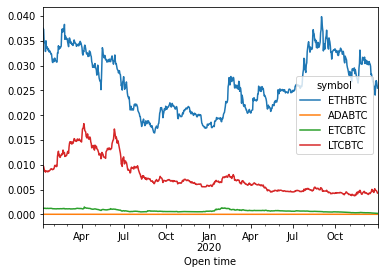

In [3]:
closing_prices = df['Close'].get()
high_prices = df['High'].get()
low_prices = df['Low'].get()
rsi= vbt.pandas_ta('RSI').run(closing_prices, 2)
ma200 = vbt.MA.run(closing_prices, 200)
#checking how this looks
closing_prices.plot()


The rules for long trades are: if price action is above its 200ma and RSI value is below 5, exit when RSI is above 60.
The rules for short trades are: if price action is below its 200ma and RSI value is above 95, exit when RSI is below 40.
The following code will create four different data frames with timestamps and boolean values.

In [4]:
long_entries = rsi.rsi_below(10) & ma200.ma_below(closing_prices)
long_exits = rsi.rsi_above(60)
short_entries = rsi.rsi_above(90) & ma200.ma_above(closing_prices)
short_exits = rsi.rsi_below(40)

long_entries['ETHBTC']

rsi_length,2
ma_window,200
Open time,
2019-01-07 00:00:00+00:00,False
2019-01-08 00:00:00+00:00,False
2019-01-09 00:00:00+00:00,False
2019-01-10 00:00:00+00:00,False
2019-01-11 00:00:00+00:00,False
...,...
2020-12-27 00:00:00+00:00,False
2020-12-28 00:00:00+00:00,False


It's time to execute the portfolio calculations.

In [5]:
# kwargs = dict(fees=0.001, freq='1D')

portfolio = vbt.Portfolio.from_signals(
    close = closing_prices,
    entries = long_entries,
    exits = long_exits,
    short_entries=short_entries,
    short_exits=short_exits,
    init_cash=[10000, 10000, 10000, 10000],
    fees=0.001, freq='1D')

We will grab the records table and join the indicators we want to include to visualise how market volatility and PnL (profit and loss) are related.

In [6]:

records = portfolio.trades.records_readable
atr7= vbt.ATR.run(high_prices, low_prices, closing_prices, 7).atr
atr60= vbt.ATR.run(high_prices, low_prices, closing_prices, 60).atr
rsi2= rsi.rsi


Let's assemble some info to get do some analysis.

In [ ]:
df_cd = pd.merge(records, atr60, how='inner', left_on='Entry Timestamp', right_index= True )
df_cd['Column2'] = df_cd['Column'].str.get(2)
df_cd['atr60'] = np.where(df_cd['Column2'] == 'ETHBTC', df_cd[(60, 'ETHBTC')], 0)
df_cd['atr60'] = np.where(df_cd['Column2'] == 'ADABTC', df_cd[(60, 'ADABTC')], df_cd['atr60'])
df_cd['atr60'] = np.where(df_cd['Column2'] == 'LTCBTC', df_cd[(60, 'LTCBTC')], df_cd['atr60'])
df_cd['atr60'] = np.where(df_cd['Column2'] == 'ETCBTC', df_cd[(60, 'ETCBTC')], df_cd['atr60'])

df_cd = pd.merge(df_cd, atr7, how='inner', left_on='Entry Timestamp', right_index= True )
df_cd['atr7'] = np.where(df_cd['Column2'] == 'ETHBTC', df_cd[(7, 'ETHBTC')], 0)
df_cd['atr7'] = np.where(df_cd['Column2'] == 'ADABTC', df_cd[(7, 'ADABTC')], df_cd['atr7'])
df_cd['atr7'] = np.where(df_cd['Column2'] == 'LTCBTC', df_cd[(7, 'LTCBTC')], df_cd['atr7'])
df_cd['atr7'] = np.where(df_cd['Column2'] == 'ETCBTC', df_cd[(7, 'ETCBTC')], df_cd['atr7'])

df_cd = pd.merge(df_cd, rsi2, how='inner', left_on='Entry Timestamp', right_index= True )
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'ETHBTC', df_cd[(2, 'ETHBTC')], 0)
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'ADABTC', df_cd[(2, 'ADABTC')], df_cd['rsi2'])
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'LTCBTC', df_cd[(2, 'LTCBTC')], df_cd['rsi2'])
df_cd['rsi2'] = np.where(df_cd['Column2'] == 'ETCBTC', df_cd[(2, 'ETCBTC')], df_cd['rsi2'])

df_cd['atr_7-60'] = df_cd['atr7'] / df_cd['atr60'] # Average True Range from last 7 days vs last 60 days
df_cd['atr%'] = df_cd["atr7"] / df_cd["Avg Exit Price"] * 100

First compare our PnL with the 7-period ATR.

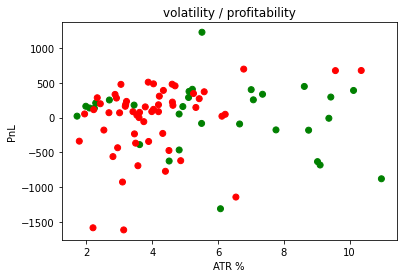

In [8]:
color= np.where( df_cd['Direction'] == 'Short','red', 'green')

plt.scatter(y=df_cd['PnL'], x = df_cd['atr%'], c= color, )
plt.title('volatility / profitability')
plt.xlabel('ATR %')
plt.ylabel("PnL") 
plt.show()


Comparision between RSI Values and profitability

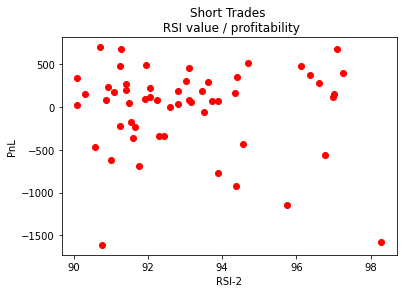

In [9]:
short_x_filt = df_cd['rsi2'][df_cd['rsi2'] > 50]
short_y_filt = df_cd['PnL'][df_cd['rsi2'] > 50]

b = plt.scatter(x= short_x_filt, y= short_y_filt, c='red')
plt.title('Short Trades \n RSI value / profitability')
plt.xlabel('RSI-2')
plt.ylabel("PnL") 
plt.show()

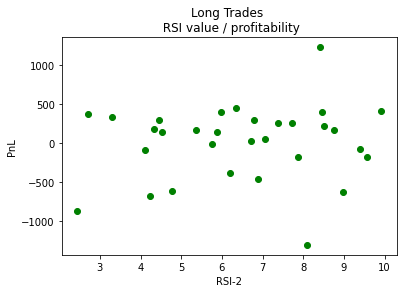

In [10]:
long_x_filt = df_cd['rsi2'][df_cd['rsi2'] < 50]
long_y_filt = df_cd['PnL'][df_cd['rsi2'] < 50]

a = plt.scatter(x= long_x_filt, y= long_y_filt, c= 'green')
plt.title('Long Trades \n RSI value / profitability')
plt.xlabel('RSI-2')
plt.ylabel("PnL")
plt.show()

Well! As you can see, we can make a few observations about this first analysis even if is simple as this one. I will continue Backtesting and going into some more complex analysis as I learn new tools and new ways to do the job. 
Thanks for your time!